<a href="https://colab.research.google.com/github/RafaGallardo7/data-science/blob/main/KaggleHousingCompetition1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.feature_selection import VarianceThreshold
import datetime

from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNetCV, Lasso
from sklearn.svm import SVR
from mlxtend.regressor import StackingRegressor
import lightgbm as lgbm

import numpy as np
from keras.layers import Dense, Activation
from keras.models import Sequential


from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from math import sqrt

In [4]:
# Load the files
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

# Get number of observations for test and train
print([len(x) for x in [train_df, test_df]])

# Combine it into one large file for data exploration and cleaning
combined_df = pd.concat([train_df, test_df])

# Get a first view
print(combined_df)

# combined_df.shape

[1460, 1459]
        Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0        1          60       RL         65.0     8450   Pave   NaN      Reg   
1        2          20       RL         80.0     9600   Pave   NaN      Reg   
2        3          60       RL         68.0    11250   Pave   NaN      IR1   
3        4          70       RL         60.0     9550   Pave   NaN      IR1   
4        5          60       RL         84.0    14260   Pave   NaN      IR1   
...    ...         ...      ...          ...      ...    ...   ...      ...   
1454  2915         160       RM         21.0     1936   Pave   NaN      Reg   
1455  2916         160       RM         21.0     1894   Pave   NaN      Reg   
1456  2917          20       RL        160.0    20000   Pave   NaN      Reg   
1457  2918          85       RL         62.0    10441   Pave   NaN      Reg   
1458  2919          60       RL         74.0     9627   Pave   NaN      Reg   

     LandContour Utilities  ... PoolAr

In [5]:
# II. Data Cleaning

# Quick look at potential missing values
print(combined_df.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   int64  
 2   MSZoning       2915 non-null   object 
 3   LotFrontage    2433 non-null   float64
 4   LotArea        2919 non-null   int64  
 5   Street         2919 non-null   object 
 6   Alley          198 non-null    object 
 7   LotShape       2919 non-null   object 
 8   LandContour    2919 non-null   object 
 9   Utilities      2917 non-null   object 
 10  LotConfig      2919 non-null   object 
 11  LandSlope      2919 non-null   object 
 12  Neighborhood   2919 non-null   object 
 13  Condition1     2919 non-null   object 
 14  Condition2     2919 non-null   object 
 15  BldgType       2919 non-null   object 
 16  HouseStyle     2919 non-null   object 
 17  OverallQual    2919 non-null   int64  
 18  OverallC

In [6]:
# Classify int variables into category if needed
combined_df["MSSubClass"] = combined_df["MSSubClass"].astype("category")
combined_df["MoSold"] = combined_df["MoSold"].astype("category")

In [7]:
# Cleaning categorical variables

# Categorical data impute with mode of neighborhood and MSSubClass or just mode of own column if missing
missing_vals = ["MSZoning", "Alley", "Utilities", 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',"Electrical",'KitchenQual','Functional','GarageType',"SaleType", 'GarageFinish','GarageQual','GarageCond','Exterior1st', 'Exterior2nd','FireplaceQu', "PoolQC", "Fence", "MiscFeature"]

for missing_val in missing_vals:
    try:
        combined_df[missing_val] = combined_df.groupby(['MSSubClass', "Neighborhood"])[missing_val].transform(lambda x: x.fillna(x.mode()[0]))
    except:
     combined_df[missing_val].fillna((combined_df[missing_val].mode()[0]), inplace=True)

In [8]:
# Add "Other" category as most elements are missing
combined_df["PoolQC"] = combined_df["PoolQC"].fillna("Other")

In [9]:
# Cleaning continuous variables

# Continuous data
missing_vals = ["LotFrontage", 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF1','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageCars', 'GarageArea',]
impute_vals = ["LotConfig" ,"Neighborhood",'BsmtFinType1', 'BsmtFinType2','BsmtQual', 'BsmtQual', 'BsmtQual','GarageType', 'GarageType']

for missing_val, impute_val in zip(missing_vals, impute_vals):
    combined_df[missing_val] = combined_df[missing_val].fillna(combined_df.groupby(impute_val)[missing_val].transform('mean'))

In [10]:
# Continuous impute data based on other continuous data
missing_vals = ['GarageYrBlt']
impute_vals = ['YearBuilt']

for missing_val, impute_val in zip(missing_vals, impute_vals):
    combined_df[missing_val] = combined_df[missing_val].fillna(combined_df[impute_val])

In [11]:
# Fill all leftovers with mean
for missing_val in combined_df.columns.values.tolist():

    if missing_val == "SalePrice":
        pass

    else:
        try:
            combined_df[missing_val] = combined_df[missing_val].fillna(combined_df[missing_val].mean())
        except:
            pass

# List of cols with missing values
print([col for col in combined_df.columns if combined_df[col].isnull().any()])

['SalePrice']


In [12]:
# III. Feature engineering

# Add and change some variables, namely the "Year" ones as it would be better to have them as "Age"
year = datetime.date.today().year
combined_df["AgeSold"] = int(year) - combined_df["YrSold"].astype(int)
combined_df["AgeGarage"] = int(year) - combined_df["GarageYrBlt"].astype(int)
combined_df["AgeBuilt"] = int(year) - combined_df["YearBuilt"].astype(int)

In [13]:
# Add some features related to total area of the house
combined_df['TotalArea'] = combined_df['TotalBsmtSF'] + combined_df['1stFlrSF'] + combined_df['2ndFlrSF'] + combined_df['GrLivArea'] +combined_df['GarageArea']
combined_df['Bathrooms'] = combined_df['FullBath'] + combined_df['HalfBath']/2
combined_df['Year average']= (combined_df['YearRemodAdd']+combined_df['YearBuilt'])/2

In [16]:
# # IV. Plotting

# # Check the sale price distribution by different types of variables
# for element in ["MSSubClass", "MSZoning", "HouseStyle","CentralAir", "PoolQC", "SaleType"]:
#     cat_plot = sns.catplot(y="SalePrice", x= element, kind="swarm", legend="full", data=combined_df, height=4.5, aspect=3 / 3,);
#     cat_plot.set_xticklabels(rotation=90)

In [17]:
# # Check the sale price distribution by different types of variables
# for element in ["1stFlrSF", "LotArea", "OverallQual", "OverallCond", "YearBuilt","ExterQual", "YrSold"]:
#     re_plot = sns.relplot(y="SalePrice", x= element, legend="full", data=combined_df, height=4.5, aspect=3 / 3,);
#     re_plot.set_xticklabels(rotation=90)

<ipython-input-18-8afac23694c5>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_mat = combined_df.corr()
<ipython-input-18-8afac23694c5>:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(corr_mat, dtype=np.bool))


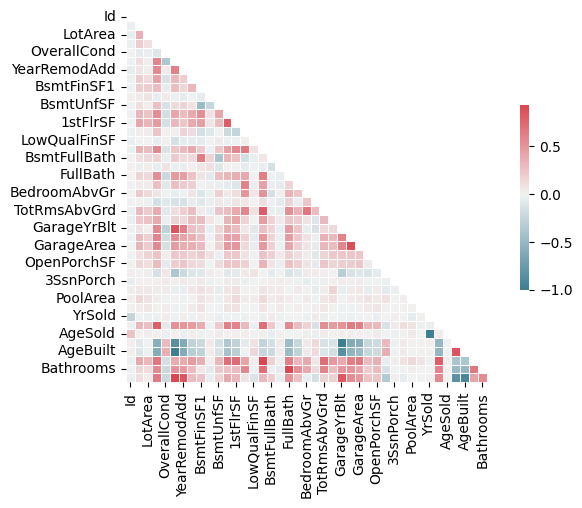

In [18]:
# Correlation matrix
corr_mat = combined_df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_mat, dtype=np.bool))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr_mat, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

In [19]:
# V. Data transformation

# Get dummies for our data set
combined_df = pd.get_dummies(combined_df)

In [20]:
# Split data set into test and train


# Split the data set so to build our model
train_df = combined_df[combined_df["SalePrice"] > 0 ]
test_df = combined_df[combined_df["SalePrice"].isna() ]
test_df = test_df.drop(["SalePrice"], axis = 1)

# Create the X and y sets
X_train_df = train_df.drop(["SalePrice"], axis = 1)
y_train_df = train_df[["Id" ,"SalePrice"]]

In [21]:
# Log transform the SalePrice as it is skewed
y_train_df["SalePrice"] = np.log1p(y_train_df["SalePrice"])

<ipython-input-21-2c224cc4013b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train_df["SalePrice"] = np.log1p(y_train_df["SalePrice"])


In [22]:
# Set the ID col as index
for element in [X_train_df, y_train_df, test_df]:
    element.set_index('Id', inplace = True)

In [23]:
# Scale the data and use RobustScaler to minimize the effect of outliers
scaler = RobustScaler()

# Scale the X_train set
X_train_scaled = scaler.fit_transform(X_train_df.values)
X_train_df = pd.DataFrame(X_train_scaled, index = X_train_df.index, columns= X_train_df.columns)

# Scale the X_test set
X_test_scaled = scaler.transform(test_df.values)
X_test_df = pd.DataFrame(X_test_scaled, index = test_df.index, columns= test_df.columns)

In [24]:
# Feature selection
threshold_n=0.55
sel = VarianceThreshold(threshold=(threshold_n* (1 - threshold_n) ))
sel_var=sel.fit_transform(X_train_df)

# Create the new datasets
X_train_df = X_train_df[X_train_df.columns[sel.get_support(indices=True)]]
X_test_df = X_test_df[X_test_df.columns[sel.get_support(indices= True)]]

# Check what we have
print(X_train_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 42 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   LotFrontage        1460 non-null   float64
 1   LotArea            1460 non-null   float64
 2   OverallQual        1460 non-null   float64
 3   OverallCond        1460 non-null   float64
 4   YearBuilt          1460 non-null   float64
 5   YearRemodAdd       1460 non-null   float64
 6   MasVnrArea         1460 non-null   float64
 7   BsmtFinSF1         1460 non-null   float64
 8   BsmtFinSF2         1460 non-null   float64
 9   BsmtUnfSF          1460 non-null   float64
 10  TotalBsmtSF        1460 non-null   float64
 11  1stFlrSF           1460 non-null   float64
 12  2ndFlrSF           1460 non-null   float64
 13  LowQualFinSF       1460 non-null   float64
 14  GrLivArea          1460 non-null   float64
 15  BsmtFullBath       1460 non-null   float64
 16  FullBath           1460 

In [26]:
# VI. Modelling

# Split our training set into train and test data
X_train, X_test, y_train, y_test = train_test_split(X_train_df, y_train_df, test_size=0.05, random_state=23)

In [28]:
# In the next part, we will run the models listed here under and stack the best ones into a stacked regression. Most of the comments are included in the code chunks.

# ElasticNet
# Lasso
# randomForest
# AdaBoost
# XGBoost
# ANN with Keras
# LightGBM
# SVM

In [38]:
# ElasticNet

# REGULARIZATION WITH ELASTIC NET
# Set parameters to iterate over
alphas = [0.000542555]
l1ratio = [0.1, 0.3,0.5, 0.9, 0.95, 0.99, 1]
# Model with iterative fitting
elastic_cv = ElasticNetCV(cv=5, max_iter=10000, alphas=alphas,  l1_ratio=l1ratio)

# Fit the model to the data
estc_reg = elastic_cv.fit(X_train, y_train)

# Predict on the test set from our training set
y_pred = estc_reg.predict(X_test)
print("ElasticRegressor RMSE:",sqrt(mean_squared_error(y_test, y_pred)))

# Create predictions
predictions = np.exp(estc_reg.predict(X_test_df))
my_pred_estc = pd.DataFrame({'Id': X_test_df.index, 'SalePrice': predictions})

# Create CSV file
my_pred_estc.to_csv('pred_estc.csv', index=False)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:1568: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02114712701628818, tolerance: 0.017690918170600266
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.031874367399257864, tolerance: 0.017690918170600266
  model = cd_fast.enet_coordinate_descent_gram(


ElasticRegressor RMSE: 0.1759215395679287


In [116]:
# LASSO

# REGULARIZATION WITH LASSO
# Set parameters to iterate over
parameters= {'alpha':[0.0001,0.0009,0.001,0.002,0.003,0.01,0.1,1,10,100]}

# Instantiate reg for gridsearch
lasso=Lasso()
# Conduct the gridsearch
lasso_reg = GridSearchCV(lasso, param_grid=parameters, scoring='neg_mean_squared_error', cv=15)

# Instantiate new lasso reg with best params
lasso_reg = Lasso(alpha= 0.0009)

# Fit the model to the data
lasso_reg.fit(X_train,y_train)

# Predict on the test set from our training set
y_pred = lasso_reg.predict(X_test)
print("LassoRegressor RMSE:",sqrt(mean_squared_error(y_test, y_pred)))

# Create predictions
predictions = np.exp(lasso_reg.predict(X_test_df))
my_pred_lasso = pd.DataFrame({'Id': X_test_df.index, 'SalePrice': predictions})

# Create CSV file
my_pred_lasso.to_csv('pred_lasso.csv', index=False)

LassoRegressor RMSE: 0.17605976400185003


In [42]:
# RANDOM FOREST

# RANDOM FOREST

# Create the parameter grid based on the results of random search
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

# Instantiate reg for gridsearch
rf = RandomForestRegressor()

# Conduct the gridsearch
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,
                          cv = 3, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
# grid_search.fit(X_train_df, y_train_df)
# print(grid_search.best_params_)

# Create a random forest with best parameters
rf_reg = RandomForestRegressor(bootstrap =  True, max_depth = 80, max_features = 'auto', min_samples_leaf = 3,
                               min_samples_split = 8, n_estimators = 300, n_jobs=-1, random_state=12)

# Fit the model to the data
rf_reg.fit(X_train, y_train)

# Predict on the test set from our training set
y_pred_rf = rf_reg.predict(X_test)
print("RandomForestRegressor RMSE:",sqrt(mean_squared_error(y_test, y_pred_rf)))

# Create predictions
predictions = np.exp(rf_reg.predict(X_test_df))
my_pred_rf = pd.DataFrame({'Id': X_test_df.index, 'SalePrice': predictions})

# Create CSV file
my_pred_rf.to_csv('pred_rf.csv', index=False)

<ipython-input-42-d56c62708a6c>:31: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_reg.fit(X_train, y_train)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


RandomForestRegressor RMSE: 0.18632859815924274


In [43]:
# ADABOOST

# ADA BOOST

# Grid search for best params
param_grid = {
 'n_estimators': [50, 100, 200],
 'learning_rate' : [0.01,0.05,0.1,0.3,1],
 'loss' : ['linear', 'square', 'exponential']
 }

# Instantiate reg for gridsearch
ab_reg = AdaBoostRegressor()

# Conduct the gridsearch
grid_search = GridSearchCV(estimator = ab_reg, param_grid = param_grid, cv = 4, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
# grid_search.fit(X_train_df, y_train_df)
# print(grid_search.best_params_)

# Create a random forest with best parameters
ab_reg = AdaBoostRegressor(learning_rate =1, loss = 'exponential', n_estimators =  50, random_state= 12)

# Fit the model to the data
ab_reg.fit(X_train, y_train)

# Predict on the test set from our training set
y_pred_ab = ab_reg.predict(X_test)
print("AdaBoostRegressor RMSE:",sqrt(mean_squared_error(y_test, y_pred_ab)))

# Create predictions
predictions = np.exp(ab_reg.predict(X_test_df))
my_pred_ab = pd.DataFrame({'Id': X_test_df.index, 'SalePrice': predictions})

# Create CSV file
my_pred_ab.to_csv('pred_ab.csv', index=False)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AdaBoostRegressor RMSE: 0.2061786672211322


In [44]:
# XGBoost

# XGBOOST

# Grid search for best params
param_grid = {'max_depth':[3,4],
          'learning_rate':[0.01,0.03],
          'min_child_weight':[1,3],
          'reg_lambda':[0.1,0.5],
          'reg_alpha':[1,1.5],
          'gamma':[0.1,0.5],
          'subsample':[0.4,0.5],
         'colsample_bytree':[0.4,0.5],
}

# Instantiate reg for gridsearch
reg = XGBRegressor()

# Conduct the gridsearch
grid_search = GridSearchCV(estimator = reg, param_grid = param_grid,
                          cv = 4, n_jobs = -1, verbose = True)

# Fit the grid search to the data
# grid_search.fit(X_train_df, y_train_df)
# print(grid_search.best_params_)

# Create a regressor with best parameters
xgb_reg = XGBRegressor(learning_rate=0.01,n_estimators=3460,
                                     max_depth=3,min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:squarederror',
nthread=-1, scale_pos_weight=1, seed=27,reg_alpha=0.00006)

# Fit the model to the data
xgb_reg.fit(X_train, y_train)

# Predict on the test set from our training set
y_pred = xgb_reg.predict(X_test)
print("XGBoostRegressor RMSE:",sqrt(mean_squared_error(y_test, y_pred)))

# Create predictions
predictions = np.exp(xgb_reg.predict(X_test_df))
my_pred_xgb = pd.DataFrame({'Id': X_test_df.index, 'SalePrice': predictions})

# Create CSV file
my_pred_xgb.to_csv('pred_xgb.csv', index=False)

XGBoostRegressor RMSE: 0.17373097162496393


In [48]:
# ANN WITH KERAS

# NEURAL NETWORK

# Initialising the ANN
# model = Sequential()

# # Adding the input layer and the first hidden layer
# model.add(Dense(32, activation = 'relu', input_dim = 320))

# # Adding the second hidden layer
# model.add(Dense(units = 317, activation = 'relu'))

# # Adding the third hidden layer
# model.add(Dense(units = 300, activation = 'relu'))

# # Adding the fourth hidden layer
# model.add(Dense(units = 200, activation = 'relu'))

# # Adding the fifth hidden layer
# model.add(Dense(units = 200, activation = 'relu'))

# # Adding the sixth hidden layer
# model.add(Dense(units = 100, activation = 'relu'))

# # Adding the seventh hidden layer
# model.add(Dense(units = 100, activation = 'relu'))

# # Adding the output layer
# model.add(Dense(units = 1))

# # Compiling the ANN
# model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# # Fitting the ANN to the Training set
# model.fit(X_train, y_train, batch_size = 10, epochs = 200)

# y_pred = model.predict(X_test)
# print("ANNRegressor RMSE:",sqrt(mean_squared_error(y_test, y_pred)))

# # Create predictions
# predictions = np.exp(model.predict(X_test_df))
# predictions = np.concatenate( predictions, axis=0 )
# my_pred_ann = pd.DataFrame({'Id': X_test_df.index, 'SalePrice': predictions})

# # Create CSV file
# my_pred_ann.to_csv('pred_ann.csv', index=False)

In [102]:
# LIGHTGBM

# LIGHTGBM
# Instantiate reg
lgbm_reg = lgbm.LGBMRegressor(
    objective='regression',
    num_leaves=4,
    learning_rate=0.01,
    n_estimators=5000,
    max_bin=200,
    bagging_fraction=0.75,
    bagging_freq=5,
    bagging_seed=7,
    feature_fraction=0.2,
    feature_fraction_seed=27,
    verbose=-1,
    #min_data_in_leaf=2,
    #min_sum_hessian_in_leaf=11
)

# Fit the model to the data
lgbm_reg.fit(X_train, y_train)

# Predict on the test set from our training set
y_pred = lgbm_reg.predict(X_test)
print("LGBMRegressor RMSE:",sqrt(mean_squared_error(y_test, y_pred)))

# Create predictions
predictions = np.exp(lgbm_reg.predict(X_test_df))
my_pred_lgbm = pd.DataFrame({'Id': X_test_df.index, 'SalePrice': predictions})

# Create CSV file
# my_pred_lgbm.to_csv('pred_lgbm.csv', index=False)
my_pred_lgbm.to_csv('submission.csv', index=False)

LGBMRegressor RMSE: 0.1683246699567288


In [84]:
# SUPPORT VECTOR MACHINE

# SVM
# Instantiate reg
svr_reg = make_pipeline(RobustScaler(), SVR(
    C=20,
    epsilon=0.008,
    gamma=0.0003,
))

# Fit the model to the data
svr_reg.fit(X_train, y_train)

# Predict on the test set from our training set
y_pred = svr_reg.predict(X_test)
print("SVRRegressor RMSE:",sqrt(mean_squared_error(y_test, y_pred)))

# Create predictions
predictions = np.exp(svr_reg.predict(X_test_df))
my_pred_svr = pd.DataFrame({'Id': X_test_df.index, 'SalePrice': predictions})

# Create CSV file
# my_pred_svr.to_csv('pred_svr.csv', index=False)
my_pred_svr.to_csv('submission.csv', index=False)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVRRegressor RMSE: 0.21032325472490188


In [83]:
# STACKEDREGRESSION
# STACKED REGRESSION

# Instantiate reg
stregr = StackingRegressor(regressors=[xgb_reg, estc_reg, lasso_reg, lgbm_reg],meta_regressor=lgbm_reg, use_features_in_secondary=True )
# Fit the model to the data
stack_reg=stregr.fit(X_train, y_train)

# Predict on the test set from our training set
y_pred = stack_reg.predict(X_test)
print("StackedRegressor RMSE:",sqrt(mean_squared_error(y_test, y_pred)))

# Create predictions
predictions = np.exp(stack_reg.predict(X_test_df))
my_pred_stacked = pd.DataFrame({'Id': X_test_df.index, 'SalePrice': predictions})

# Create CSV file
# my_pred_stacked.to_csv('pred_stacked.csv', index=False)
my_pred_stacked.to_csv('submission.csv', index=False)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02114712701628818, tolerance: 0.017690918170600266
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.031874367399257864, tolerance: 0.017690918170600266
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but ElasticNetCV was fitted witho

StackedRegressor RMSE: 0.1699236647051134
